In [1]:
cd ..

/Users/estevao.uyra/dev/personal/recicla


In [2]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt
import cv2
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [3]:
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
%matplotlib inline

In [4]:
PHOTO_PATH = "./photos/real/"

# Functions

In [89]:
def get_photo_arrays():
    paths = glob(PHOTO_PATH+'*')
    for path in paths:
        yield np.array(Image.open(path))
        
def get_detector(threshold=0.1):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
    cfg["MODEL"]["DEVICE"] = 'cpu'
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold  # set threshold for this model
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
    predictor = DefaultPredictor(cfg)
    return predictor, cfg

def build_image(im, out=None, cfg=None):
    if out is None:
        out = DefaultPredictor(cfg)(im)
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    v = v.draw_instance_predictions(out["instances"].to("cpu"))
    return cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB), v

def get_segment(threshold=0.1, instance=True):
    if instance:
        model_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
    else:
        model_path = "COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(model_path))
    cfg["MODEL"]["DEVICE"] = 'cpu'
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold  # set threshold for this model
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_path)
    predictor = DefaultPredictor(cfg)
    return predictor, cfg

def get_subimages(im, out, extra=0):
    for b in out['instances'].pred_boxes:
        x1, y1, x2, y2 = np.array(b).astype(int).squeeze()
        yield im[max(y1-extra, 0):y2+extra, max(x1-extra, 0):x2+extra]
        
def biggest_mask(out):
    try:
        return max(out['instances'].pred_masks, key=lambda m: np.sum(np.array(m)))
    except:
        return None

# Original photos

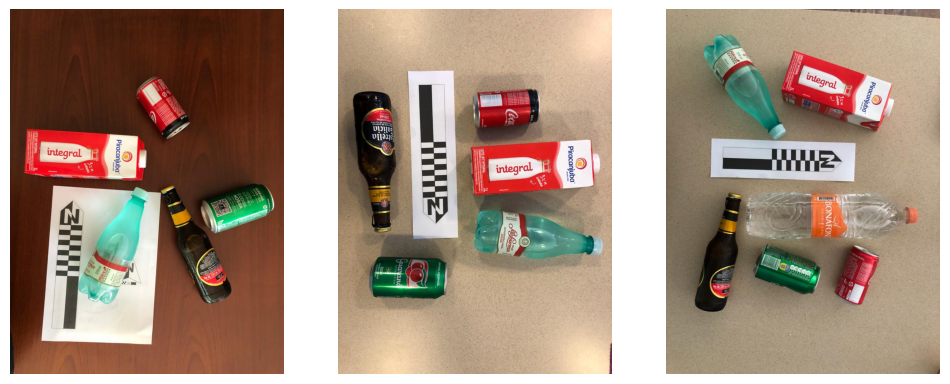

In [6]:
fig, axes = plt.subplots(1,3, figsize=(12,8), dpi=100)

for ax, photo in zip(axes, get_photo_arrays()):
    ax.imshow(photo)
    ax.set_axis_off()


# Object detection

In [7]:
detector, cfg = get_detector(0.1)

In [8]:
photo.mean(axis=2).shape

(1024, 768)

/usr/local/anaconda3/envs/recicla/lib/python3.7/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


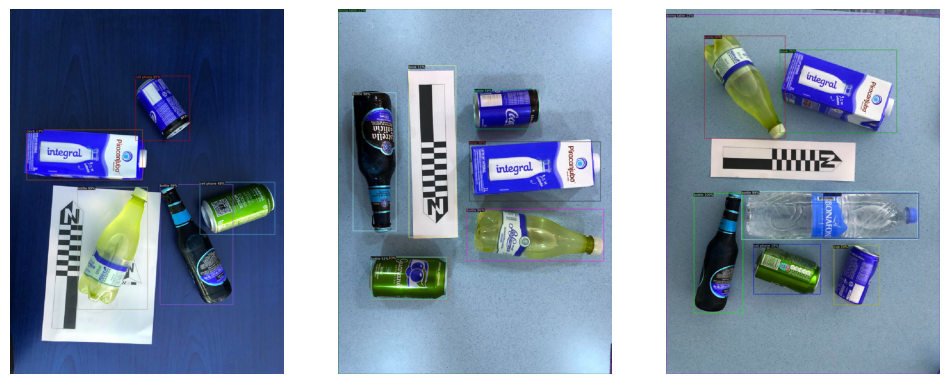

In [9]:
fig, axes = plt.subplots(1,3, figsize=(12,8), dpi=100)
for ax, photo in zip(axes, get_photo_arrays()):
    outputs= detector(photo)
    
    im, v = build_image(photo, outputs, cfg=cfg)
    ax.imshow(im)
    ax.set_axis_off()

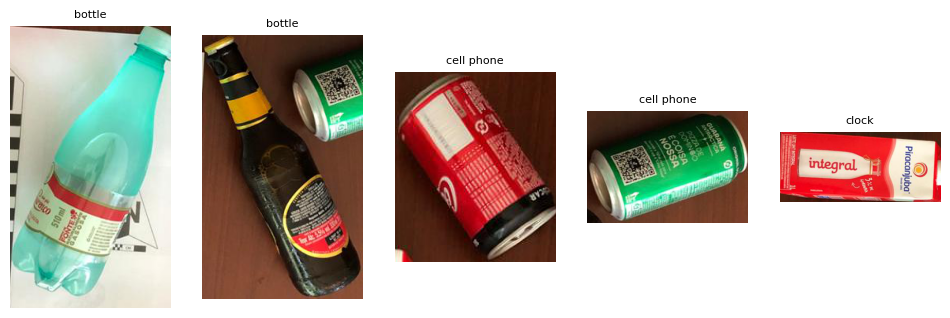

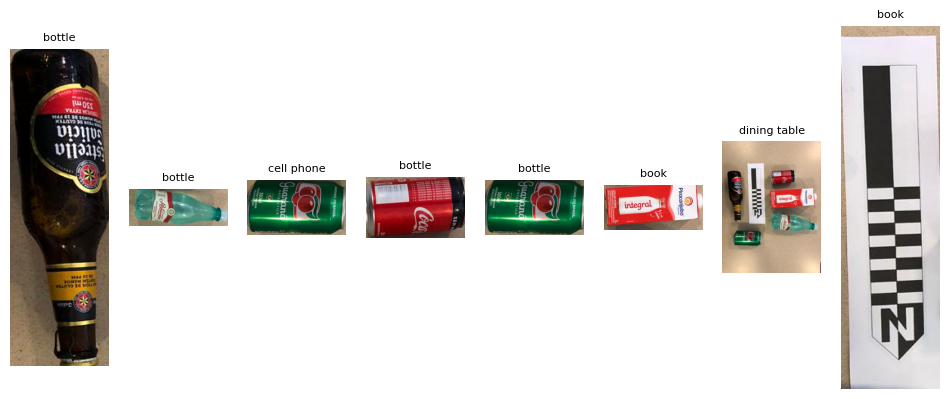

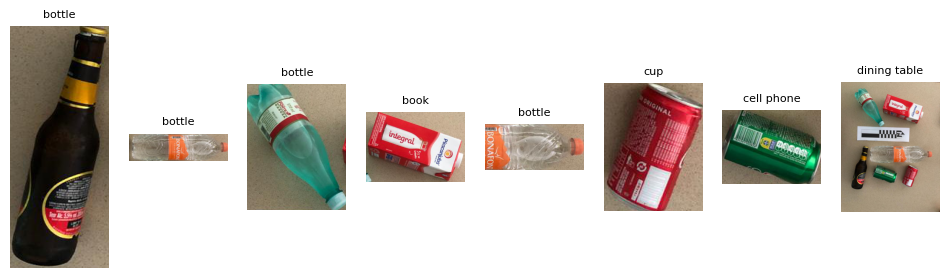

In [10]:
for ax, photo in zip(axes, get_photo_arrays()):
    outputs= detector(photo)
    
    fig, axes = plt.subplots(1,len(outputs['instances'].pred_boxes), figsize=(12,8), dpi=100)
    for i,(b, ax) in enumerate(zip(outputs['instances'].pred_boxes, axes)):
        x1, y1, x2, y2 = np.array(b).astype(int).squeeze()
        ax.imshow(photo[y1:y2, x1:x2])
        ax.set_axis_off()
        ax.set_title(MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
     .thing_classes[outputs['instances'][i].pred_classes], fontsize=8)

# Instance segmentation

In [34]:
segmentor, cfg = get_segment(0.05)

model_final_a3ec72.pkl: 254MB [00:34, 7.46MB/s]                               


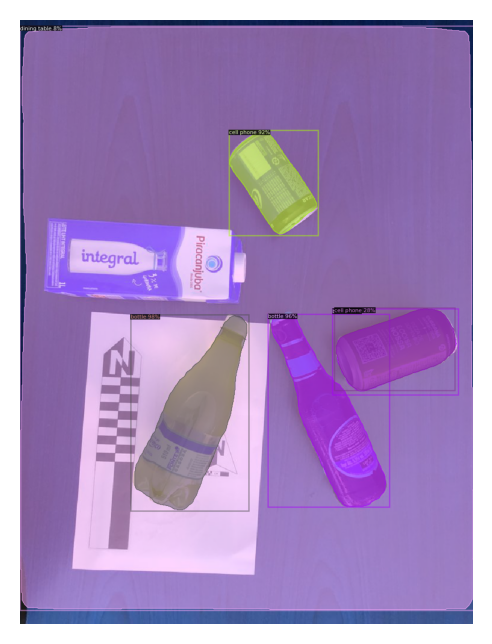

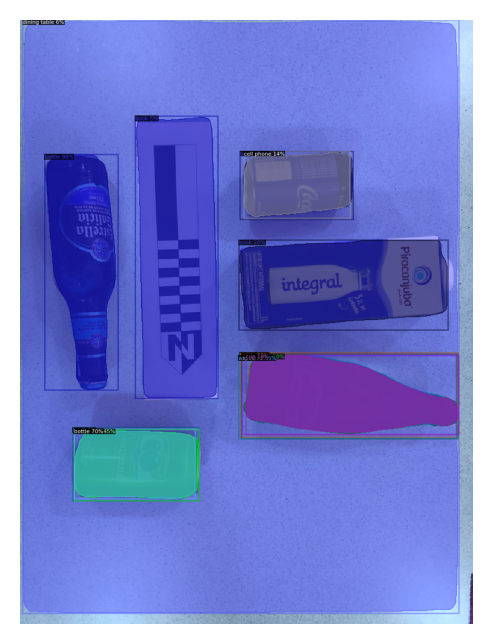

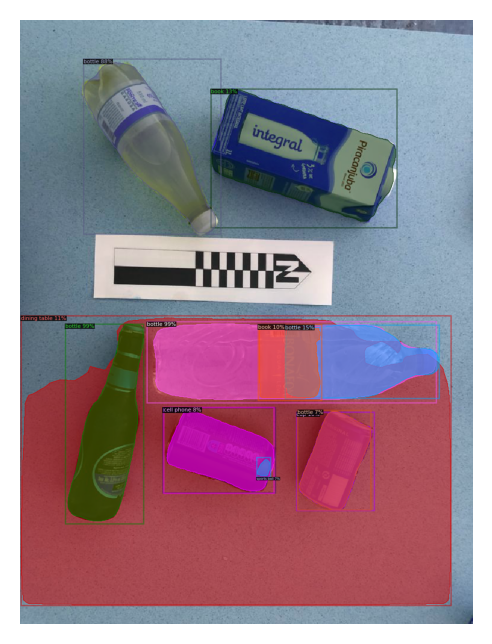

In [36]:
for ax, photo in zip(axes, get_photo_arrays()):
    outputs= segmentor(photo)
    
    fig, ax = plt.subplots(dpi=200)
    im, v = build_image(photo, outputs, cfg=cfg)
    ax.imshow(im)
    ax.set_axis_off()

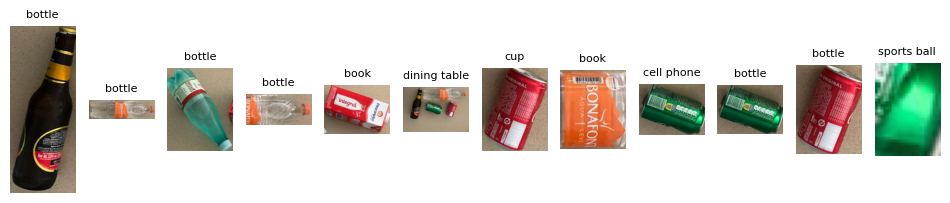

In [37]:
fig, axes = plt.subplots(1,len(outputs['instances'].pred_boxes), figsize=(12,8), dpi=100)
for i, (b, ax) in enumerate(zip(outputs['instances'].pred_boxes, axes)):
    x1, y1, x2, y2 = np.array(b).astype(int).squeeze()
    ax.imshow(photo[y1:y2, x1:x2])
    ax.set_axis_off()
    ax.set_title(MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
 .thing_classes[outputs['instances'][i].pred_classes], fontsize=8)

[(118.75003567351602, 118.75003567351602),
 (139.01947773972609, 139.01947773972609),
 (120.19716752283108, 120.19716752283108)]

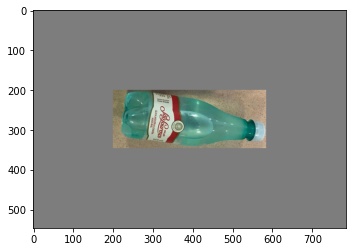

In [68]:
pad = 200
cv = (subp.mean(), subp.mean())
plt.imshow(np.pad(subp, pad, constant_values=cv)[:,:,pad:-pad])

In [46]:
subp.shape

(146, 384, 3)

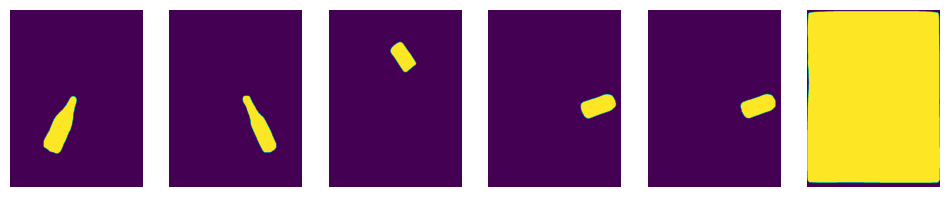

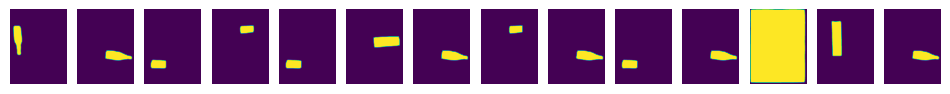

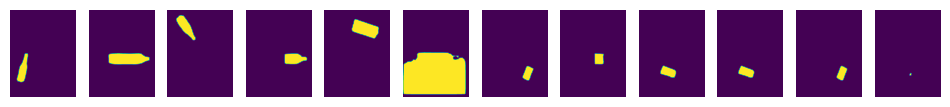

In [98]:
for ax, photo in zip(axes, get_photo_arrays()):
    outputs= segmentor(photo)
    
    fig, axes = plt.subplots(1,len(outputs['instances'].pred_masks), figsize=(12,8), dpi=100)
    for b, ax in zip(outputs['instances'].pred_masks, axes):
        ax.imshow(b.squeeze())
        ax.set_axis_off()

# Segmentation after selection

CPU times: user 6.7 s, sys: 730 ms, total: 7.43 s
Wall time: 6.54 s
CPU times: user 6.24 s, sys: 726 ms, total: 6.97 s
Wall time: 6.13 s
CPU times: user 5.99 s, sys: 657 ms, total: 6.65 s
Wall time: 5.87 s
CPU times: user 5.37 s, sys: 582 ms, total: 5.96 s
Wall time: 5.28 s
CPU times: user 5.5 s, sys: 632 ms, total: 6.14 s
Wall time: 5.41 s
CPU times: user 6.59 s, sys: 721 ms, total: 7.31 s
Wall time: 6.44 s
CPU times: user 6.71 s, sys: 739 ms, total: 7.45 s
Wall time: 6.57 s
CPU times: user 7.26 s, sys: 828 ms, total: 8.09 s
Wall time: 7.1 s
CPU times: user 6.92 s, sys: 743 ms, total: 7.66 s
Wall time: 6.76 s
CPU times: user 5.98 s, sys: 659 ms, total: 6.64 s
Wall time: 5.86 s
CPU times: user 5.8 s, sys: 618 ms, total: 6.42 s
Wall time: 5.66 s
CPU times: user 6.08 s, sys: 672 ms, total: 6.75 s
Wall time: 5.97 s
CPU times: user 6.49 s, sys: 670 ms, total: 7.16 s
Wall time: 6.34 s
CPU times: user 6.38 s, sys: 751 ms, total: 7.14 s
Wall time: 6.28 s
CPU times: user 8 s, sys: 836 ms, tota

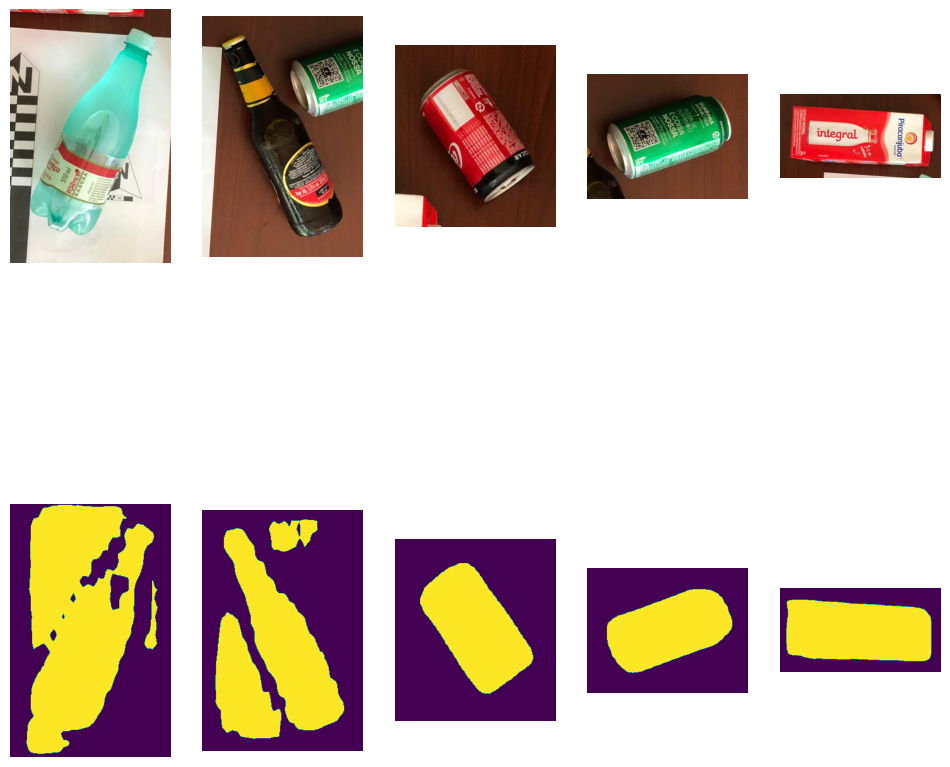

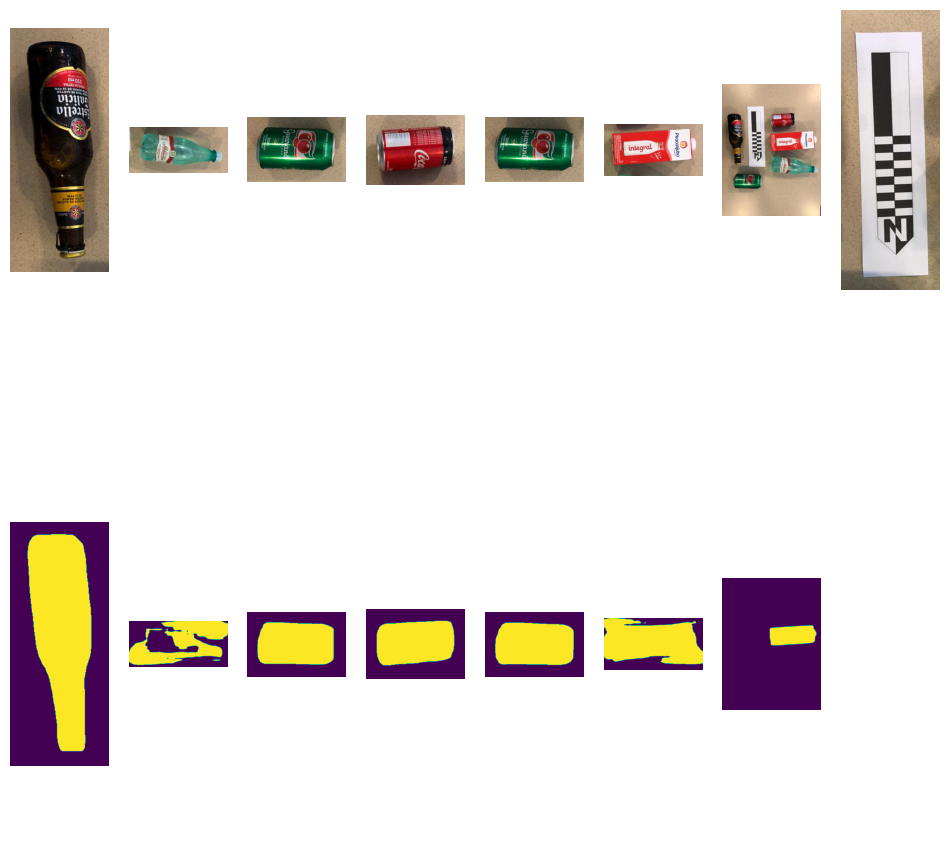

In [91]:
for ax, photo in zip(axes, get_photo_arrays()):
    %time outputs= detector(photo)
    
    fig, axes = plt.subplots(2,len(outputs['instances'].pred_boxes), figsize=(12,12), dpi=100)
    for i,(subp, ax) in enumerate(zip(get_subimages(photo, outputs, extra=30), axes.T)):
        ax[0].imshow(subp)
        ax[0].set_axis_off()
#         ax[0].set_title(MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
#      .thing_classes[outputs['instances'][i].pred_classes], fontsize=8)
        
        pad = 200
        cv = (subp.mean(), subp.mean())
        subpad = np.pad(subp, pad, constant_values=cv)[:,:,pad:-pad]
        %time segout= segmentor(subpad)
#         im, v = build_image(subpad, outputs, cfg=cfg)
        
        mask = biggest_mask(segout)
        if mask is not None:
            ax[1].imshow(mask[pad:-pad, pad:-pad])
        ax[1].set_axis_off()

#     break